In [1]:
'''
Esther Aruti
BME I5000: Medical Imaging and Signal Processing
October 8, 2024
Assignment #3: Coregistration Part 1 + 2
'''

import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
from PIL import Image
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import fmin

In [2]:
### LOAD IN HEAD IMAGES ###
img = Image.open('head-1.png')
img = np.array(img)

img1 = img[:,25:225,0]
print(img1.shape)

img2 = Image.open('head-2.png')
img2 = np.array(img2)
img2 = img2[:,25:225,0]
print(img2.shape)

(200, 200)
(200, 200)


In [3]:
### TEST IMAGES ###
'''
I created two images to test the transformation.
One image is the original image, and the other is the 
same original image but shifted by 10. If the functions work
as they should, the optimal parameters should be to just 
shift the image back down by 10.
'''

'''
fig,ax = plt.subplots(1,2)
img1 = img[10:110, :100, 0]
print(img1.shape)
ax[0].imshow(img1)


img2 = img[20:120, :100, 0]
print(img2.shape)
ax[1].imshow(img2)
plt.show()
'''


def mytransform(img,scale,xshift,yshift,alpha):
    alpha = alpha + 55 # had to add this to make it match the original image
    
    # Get image dimensions
    Nx, Ny = img.shape
    x = np.linspace(0, Nx-1, Nx)
    y = np.linspace(0, Ny-1, Ny)

    # Make interpolator
    interpolator = scipy.interpolate.RegularGridInterpolator((x, y), img, bounds_error=False, fill_value=0)

    # Make a new grid for new img with xshift and yshift
    Nx2, Ny2 = img.shape # Output image size
    x2 = np.linspace(0, Nx2-1, Nx2)/Nx2*Nx
    y2 = np.linspace(0, Ny2-1, Ny2)/Ny2*Ny
    X, Y = np.meshgrid(x2, y2)

    # Get the coordinates of the center of the original image
    cx, cy = Nx/2, Ny/2 

    # Flatten the grid and subtract the center to rotate around the center
    X_flat = X.flatten() - cx
    Y_flat = Y.flatten() - cy

    # Stack the coordinates
    coords = np.vstack([X_flat, Y_flat])

    # Create a rotation matrix
    rotation_matrix = np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]
    ])

    # Apply the rotation matrix and scaling
    transformed_coords = scale * (rotation_matrix @ coords)

    # Translate the points back to the image coordinates after rotation
    transformed_coords[0] += cx + xshift
    transformed_coords[1] += cy + yshift
    new_points = np.vstack(transformed_coords).T  # Transpose after stacking

    # Apply the interpolator
    newimg = interpolator(new_points).reshape(Nx2, Ny2)

    # Flip the image to mirror it to the original
    newimg = np.fliplr(newimg)

    return newimg


# creating error function
def error_function(params, img1, img2):
    scale, xshift, yshift, alpha = params
    transformed_img = mytransform(img2, scale, xshift, yshift, alpha)

    # reshape to have img and transformed img sizes match
    if img1.size > transformed_img.size:
       img1 = img1[0:transformed_img.shape[0], 0:transformed_img.shape[1]]

    if transformed_img.size > img1.size:
        transformed_img = transformed_img[0:img1.shape[0], 0:img1.shape[1]]

    # get the mean squared error btwn the two imgs
    mse = np.mean((img1 - transformed_img) ** 2)
    return mse


# coregistration function
def coregistration_function(img1, img2):

    # create the starting parameters
    init_param = [1.0, 0,  0, 0]

    # Minimize the error function
    result = fmin(error_function, init_param, args=(img1, img2))
    
    # Get optimal parameters
    params_opt = result
    img_transformed = mytransform(img2, *params_opt)
    
    return params_opt, img_transformed

Optimization terminated successfully.
         Current function value: 5123.203513
         Iterations: 204
         Function evaluations: 370


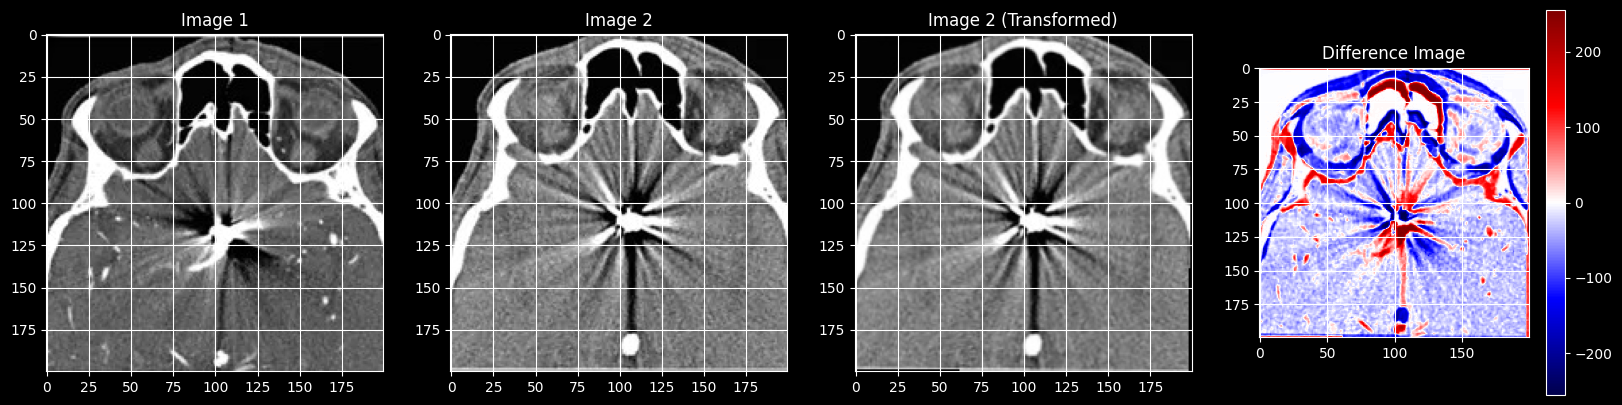

Optimal parameters (scale, xshift, yshift, alpha): [ 0.99707001  0.00635114  0.00306351 -0.01455097]


In [4]:
#### TEST ON IMAGES

# Perform coregistration
params_opt, img_transformed = coregistration_function(img1, img2)


# Display the results
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title('Image 1')
plt.imshow(img1, cmap='gray')
plt.grid(True)  
plt.axis('on')  

plt.subplot(1, 4, 2)
plt.title('Image 2')
plt.imshow(img2, cmap='gray')
plt.grid(True)  
plt.axis('on')  

plt.subplot(1, 4, 3)
plt.title('Image 2 (Transformed)')
plt.imshow(img_transformed, cmap='gray')
plt.grid(True)  
plt.axis('on')  

plt.subplot(1, 4, 4)
plt.title('Difference Image')
plt.imshow(img1 - img_transformed, cmap='seismic')
plt.colorbar()
plt.grid(True)
plt.axis('on')

plt.show()


# Print optimal parameters
print('Optimal parameters (scale, xshift, yshift, alpha):', params_opt)